In [1]:
from __future__ import division, print_function
!pip install textblob
!pip install gensim
from tensorflow import keras
from sklearn.model_selection import train_test_split

import numpy as np, pandas as pd
from numpy import array
from numpy import asarray
from numpy import zeros
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Flatten
from keras.layers import Embedding
from keras.initializers import Constant
from keras.layers import Bidirectional,Dense,Dropout,LSTM,Dropout, Activation,Add,BatchNormalization,dot,Input,concatenate,SpatialDropout1D,Lambda
from keras import optimizers
from keras import backend as K
from keras.models import model_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

import nltk
nltk.download('punkt')
nltk.download('stopwords')

import numpy as np
import collections
import os
import pickle
from textblob import TextBlob
import re

import matplotlib.pyplot as plt
from nltk.corpus import stopwords





    100% |████████████████████████████████| 645kB 29.0MB/s 
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 24.2MB 1.9MB/s 
    100% |████████████████████████████████| 40kB 22.7MB/s 
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/f7/a6/ff/9ab5842c14e50e95a06a4675b0b4a689c9cab6064dac2b01d0
  Running setup.py bdist_wheel for bz2file ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
!pip install pydot

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
DATA_DIR = "InferSent/encoder/data"
EMBED_SIZE = 4096
QA_TRAIN_FILE = "train.tsv"
QA_EMBED_SIZE = 64
BATCH_SIZE = 32
NBR_EPOCHS = 20
vocab_size = 5467
stop = set(stopwords.words('english'))

In [4]:
train = pd.read_csv("InferSent/encoder/data/train.tsv",sep='\t')
train.head(3)

,ID,Question Stem,Choices,Complete Question,Answer Key
0,7-980,The sun is responsible for,(A) puppies learning new tricks (B) children g...,The sun is responsible for (A) puppies learnin...,D
1,7-584,When standing miles away from Mount Rushmore,(A) the mountains seem very close (B) the moun...,When standing miles away from Mount Rushmore (...,D
2,7-870,When food is reduced in the stomach,(A) the mind needs time to digest (B) take a s...,When food is reduced in the stomach (A) the mi...,C


In [5]:
#Create new features from the answer choices  
for index, row in train.iterrows():
    ans = re.split("(\([A-Z]\))", row['Choices'])
    ans.remove('')
    train.set_value(index,'OptionA',ans[1])
    train.set_value(index,'OptionB',ans[3])
    train.set_value(index,'OptionC',ans[5])
    train.set_value(index,'OptionD',ans[7])
    
#Find the answer key and replace it with the value   
for index, row in train.iterrows():
    ans = re.split("(\([A-Z]\))", row['Choices'])
    ans.remove('')
    if row['Answer Key'] == 'A':
        train.set_value(index,'Result',ans[1])
    elif row['Answer Key'] == 'B':
        train.set_value(index,'Result',ans[3])
    elif row['Answer Key'] == 'C':
        train.set_value(index,'Result',ans[5])
    elif row['Answer Key'] == 'D':
        train.set_value(index,'Result',ans[7])     

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:21: FutureWar

In [6]:
num_of_categories = 4957
shuffled = train.reindex(np.random.permutation(train.index))
a = shuffled[shuffled['Answer Key'] == 'A'][:num_of_categories]
b = shuffled[shuffled['Answer Key'] == 'B'][:num_of_categories]
c = shuffled[shuffled['Answer Key'] == 'C'][:num_of_categories]
d = shuffled[shuffled['Answer Key'] == 'D'][:num_of_categories]
concated = pd.concat([a,b,c,d], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [7]:
from keras.utils.np_utils import to_categorical
#One-hot encode the labels
concated.loc[concated['Answer Key'] == 'A', 'LABEL'] = 0
concated.loc[concated['Answer Key'] == 'B', 'LABEL'] = 1
concated.loc[concated['Answer Key'] == 'C','LABEL'] = 2
concated.loc[concated['Answer Key'] == 'D','LABEL'] = 3
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=4)
print(labels[:10])
if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1)    

4074    3
3977    3
1283    0
1723    1
1560    1
2124    1
61      0
395     0
3051    2
2967    2
Name: LABEL, dtype: int64
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [8]:
#train = train.drop(['ID', 'Choices', 'Complete Question','Answer Key'], axis=1)
train.head(3)

,ID,Question Stem,Choices,Complete Question,Answer Key,OptionA,OptionB,OptionC,OptionD,Result
0,7-980,The sun is responsible for,(A) puppies learning new tricks (B) children g...,The sun is responsible for (A) puppies learnin...,D,puppies learning new tricks,children growing up and getting old,flowers wilting in a vase,"plants sprouting, blooming and wilting","plants sprouting, blooming and wilting"
1,7-584,When standing miles away from Mount Rushmore,(A) the mountains seem very close (B) the moun...,When standing miles away from Mount Rushmore (...,D,the mountains seem very close,the mountains are boring,the mountains look the same as from up close,the mountains seem smaller than in photographs,the mountains seem smaller than in photographs
2,7-870,When food is reduced in the stomach,(A) the mind needs time to digest (B) take a s...,When food is reduced in the stomach (A) the mi...,C,the mind needs time to digest,take a second to digest what I said,nutrients are being deconstructed,reader's digest is a body of works,nutrients are being deconstructed


In [9]:
embeddings_index = dict()
f = open('InferSent/dataset/GloVe/glove.840B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [10]:
import tensorflow as tf

#Split question, candidate answers and right answer to test and train data 
X_Question = train['Question Stem']
X_Answers = train[['OptionA','OptionB','OptionC','OptionD',]]
Y = train['Result']

#Global variable initilisation 
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50

In [11]:
## Iterate over the questions to remove stopwords
lines_without_stopwords_questions=[] 
for line in X_Question.values: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords_questions.append(new_line)
question_texts = lines_without_stopwords_questions

In [12]:
#Generate tokenised text for questions
#Generate question Embedding Matrix
t = Tokenizer(num_words=MAX_NUM_WORDS)
t.fit_on_texts(question_texts)

word_index = t.word_index
print('Found %s unique tokens in questions.' % len(word_index)) 

# integer encode the questions
encoded_docs = t.texts_to_sequences(question_texts)
# pad documents to a max length of 100 words
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
#
padded_docs_reshaped = np.delete(padded_docs,1,1)

## EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))


for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 5249 unique tokens in questions.


In [13]:
## Iterate over the candidate answers to remove stopwords
lines_without_stopwords_candidate_answers=[] 
for answers in X_Answers.values: 
    for answer in answers:
        answer = answer.lower()
        line_by_words = re.findall(r'(?:\w+)', answer, flags = re.UNICODE) # remove punctuation ans split
        new_line=[]
        for word in line_by_words:
            if word not in stop:
                new_line.append(word)
    lines_without_stopwords_candidate_answers.append(new_line)
answer_texts = lines_without_stopwords_candidate_answers

In [14]:
#Generate tokenised text for candidate answers
#Generate candidate answer Embedding Matrix
t_candidate_ans = Tokenizer(num_words=MAX_NUM_WORDS)
t_candidate_ans.fit_on_texts(answer_texts)

word_index_candidate_ans = t_candidate_ans.word_index
print('Found %s unique tokens in answers.' % len(word_index_candidate_ans)) 

# integer encode the questions
encoded_docs_candidate_ans = t_candidate_ans.texts_to_sequences(answer_texts)

# pad documents to a max length of 100 words
padded_docs_candidate_ans = pad_sequences(encoded_docs_candidate_ans, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM_CANDIDATE_ANS = embeddings_index.get('a').shape[0]
num_words_candidate_ans = min(MAX_NUM_WORDS, len(word_index_candidate_ans)) + 1
embedding_matrix_candidate_ans = np.zeros((num_words_candidate_ans, EMBEDDING_DIM_CANDIDATE_ANS))


for word, i in word_index_candidate_ans.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector_candidate_ans = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector_candidate_ans is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_candidate_ans[i] = embedding_vector_candidate_ans
        
print(embedding_matrix_candidate_ans, num_words_candidate_ans )    

Found 3951 unique tokens in answers.
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.036665    0.20106     0.28510001 ... -0.34485     0.16798
  -0.16952001]
 [-0.43511999  0.028351    0.49110001 ... -0.47150999  0.43009999
   0.36572999]
 ...
 [ 0.23746     0.050147    0.032209   ...  0.57862002  0.29216
  -0.21355   ]
 [ 0.92971998  0.48074999  0.60821998 ... -1.06930006  0.38532001
   0.68383002]
 [ 0.80149001 -0.55936998 -0.0053804  ...  0.14056     0.2823
  -0.12672   ]] 3952


In [15]:
## Iterate over the predicted answers to remove stopwords
lines_without_stopwords_predicted_answers=[] 
for line in Y.values: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords_predicted_answers.append(new_line)
pred_answer_texts = lines_without_stopwords_predicted_answers

In [16]:
#Generate tokenised text for predicted answers
#Generate predicated answer Embedding Matrix

t_ans = Tokenizer(num_words=MAX_NUM_WORDS)
t_ans.fit_on_texts(pred_answer_texts)
word_index_ans = t_ans.word_index
print('Found %s unique tokens in answers.' % len(word_index_ans)) 

# integer encode the questions
encoded_docs_ans = t_ans.texts_to_sequences(pred_answer_texts)

# pad documents to a max length of 100 words
padded_docs_ans = pad_sequences(encoded_docs_ans, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


# EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM_ANS = embeddings_index.get('a').shape[0]
num_words_ans = min(MAX_NUM_WORDS, len(word_index_ans)) + 1
embedding_matrix_ans = np.zeros((num_words_ans, EMBEDDING_DIM_ANS))


for word, i in word_index_ans.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector_ans = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector_ans is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ans[i] = embedding_vector_ans

embedding_matrix_ans.shape

Found 4525 unique tokens in answers.


(4526, 300)

In [17]:
#Get the knowledge text
# Generate word embeddings from knowledge text
sentences = []
with open('InferSent/encoder/data/openbook.txt') as f:
    for line in f:
        sentences.append(line.strip())
print(len(sentences))


lines_without_stopwords_knowledge_text=[] 
for line in sentences : 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords_knowledge_text.append(new_line)
knowledge_texts = lines_without_stopwords_knowledge_text


t_knowledge_text = Tokenizer(num_words=MAX_NUM_WORDS)
t_knowledge_text.fit_on_texts(knowledge_texts)
word_index_knowledge_text = t_knowledge_text.word_index
print('Found %s unique tokens in answers.' % len(word_index_knowledge_text)) 

# integer encode the questions
encoded_docs_knowledge_text= t_knowledge_text.texts_to_sequences(knowledge_texts)

# pad documents to a max length of 100 words
padded_docs_knowledge_text = pad_sequences(encoded_docs_knowledge_text, maxlen=MAX_SEQUENCE_LENGTH, padding='post')



# EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM_KT = embeddings_index.get('a').shape[0]
num_words_knowledge_text = min(MAX_NUM_WORDS, len(word_index_knowledge_text)) + 1
embedding_matrix_knowledge_text = np.zeros((num_words_knowledge_text, EMBEDDING_DIM_KT))


for word, i in word_index_knowledge_text.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector_knowledge_text = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if  embedding_vector_knowledge_text is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_knowledge_text[i] = embedding_vector_knowledge_text

embedding_matrix_knowledge_text.shape

1326
Found 1734 unique tokens in answers.


(1735, 300)

##CREATE TRAINING,TESTING AND VALIDATION DATASET FROM TOKENISED QUESTION(X1),CONTEXT TEXT (X2) AND LABELS(Y)

In [18]:
X_question = padded_docs
X_context = padded_docs_knowledge_text
X_answers = padded_docs_candidate_ans

X_Question_train,X_Question_test,X_Answer_train,X_Answer_test,Y_train, Y_test = \
train_test_split(X_question,X_answers,labels,test_size=0.25, random_state=42)
print(X_Question_train.shape, X_Question_test.shape,X_Answer_train.shape)

(3717, 50) (1240, 50) (3717, 50)


In [19]:

# X_Question_train, X_Question_test,X_Answers_train,X_Answers_test,Y_train, Y_test = train_test_split(X_Question,X_Answers,Y, test_size=0.30)
# print(X_Question_train.shape ,X_Question_test.shape, X_Answers_train.shape, X_Answers_test.shape,Y_train.shape,Y_test.shape)

In [20]:
#Create an Embedding layer for both question and candidate answers 
# note that we set trainable = False so as to keep the embeddings fixed
# embedding_layer_questions = Embedding(num_words,
#                             EMBEDDING_DIM,
#                             embeddings_initializer=Constant(embedding_matrix),
#                             input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=False)


# embedding_layer_candidate_answers = Embedding(num_words,
#                             EMBEDDING_DIM,
#                             embeddings_initializer=Constant(embedding_matrix_candidate_ans),
#                             input_length=MAX_SEQUENCE_LENGTH,mask_zero=True,
#                             trainable=False)

(5250, 300)


Text(0.5,1,'example vectors')

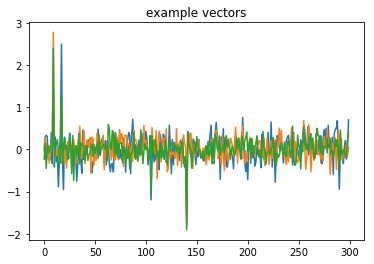

In [21]:
print(embedding_matrix.shape)
plt.plot(embedding_matrix[16])
plt.plot(embedding_matrix[37])
plt.plot(embedding_matrix[18])
plt.title('example vectors')

(3952, 300)


Text(0.5,1,'example vectors')

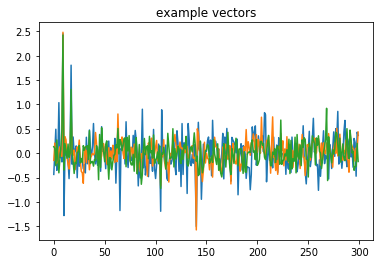

In [22]:
print(embedding_matrix_candidate_ans.shape)
plt.plot(embedding_matrix[15])
plt.plot(embedding_matrix[36])
plt.plot(embedding_matrix[20])
plt.title('example vectors')

In [23]:
training_question_idx = np.random.randint(padded_docs.shape[0], size=3569)
test_question_idx = np.random.randint(padded_docs.shape[0], size=892)
validate_question_idx = np.random.randint(padded_docs.shape[0], size=496)

training_candidate_answers_idx = np.random.randint(padded_docs_candidate_ans.shape[0], size=3569)
test_candidate_answers_idx= np.random.randint(padded_docs_candidate_ans.shape[0], size=892)
validate_candidate_answers_idx= np.random.randint(padded_docs_candidate_ans.shape[0], size=496)

training_answers_idx = np.random.randint(padded_docs_ans.shape[0], size=3569)
test_answers_idx= np.random.randint(padded_docs_ans.shape[0], size=892)
validate_answers_idx= np.random.randint(padded_docs_ans.shape[0], size=496)


training_Q, test_Q, val_Q = padded_docs[training_question_idx,:], padded_docs[test_question_idx,:], padded_docs[validate_question_idx,:] 
training_A, test_A, val_A = padded_docs_ans[training_answers_idx,:], padded_docs_ans[test_answers_idx,:], padded_docs_ans[validate_answers_idx,:] 
training_C_A, test_C_A, val_C_A = padded_docs_candidate_ans[training_candidate_answers_idx,:], padded_docs_candidate_ans[test_candidate_answers_idx,:], padded_docs_candidate_ans[validate_candidate_answers_idx,:]

print(training_Q.shape,training_A.shape,training_C_A.shape)

(3569, 50) (3569, 50) (3569, 50)


In [24]:
#####################Option A ##########################################
t_optionA = Tokenizer()
t_optionA.fit_on_texts(X_Answers['OptionA'])

word_index_optionA = t_optionA.word_index
print('Found %s unique tokens in questions.' % len(word_index_optionA)) 

# integer encode the questions
encoded_docs_optionA = t_optionA.texts_to_sequences(X_Answers['OptionA'])
# pad documents to a max length of 100 words
padded_docs__optionA = pad_sequences(encoded_docs_optionA, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


# EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM_ANS_OPTIONA = embeddings_index.get('a').shape[0]
num_words_ans_optionA = min(MAX_NUM_WORDS, len(word_index_optionA)) + 1
embedding_matrix_ans_option_A = np.zeros((num_words_ans_optionA, EMBEDDING_DIM_ANS_OPTIONA))


for word, i in word_index_optionA.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector_ans_optionA = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector_ans_optionA is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ans_option_A[i] = embedding_vector_ans_optionA


#####################Option B ##########################################
t_optionB = Tokenizer(num_words=MAX_NUM_WORDS)
t_optionB.fit_on_texts(X_Answers['OptionB'])

word_index_optionB = t_optionB.word_index
print('Found %s unique tokens in questions.' % len(word_index_optionB)) 

# integer encode the questions
encoded_docs_optionB = t_optionB.texts_to_sequences(X_Answers['OptionB'])
# pad documents to a max length of 100 words
padded_docs__optionB = pad_sequences(encoded_docs_optionB, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


# EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM_ANS_OPTIONB = embeddings_index.get('a').shape[0]
num_words_ans_optionB = min(MAX_NUM_WORDS, len(word_index_optionB)) + 1
embedding_matrix_ans_option_B = np.zeros((num_words_ans_optionB, EMBEDDING_DIM_ANS_OPTIONB))


for word, i in word_index_optionB.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector_ans_optionB = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector_ans_optionB is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ans_option_B[i] = embedding_vector_ans_optionB

        
#####################Option C ##########################################
t_optionC = Tokenizer(num_words=MAX_NUM_WORDS)
t_optionC.fit_on_texts(X_Answers['OptionC'])

word_index_optionC = t_optionC.word_index
print('Found %s unique tokens in questions.' % len(word_index_optionC)) 

# integer encode the questions
encoded_docs_optionC = t_optionC.texts_to_sequences(X_Answers['OptionC'])
# pad documents to a max length of 100 words
padded_docs__optionC = pad_sequences(encoded_docs_optionC, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


# EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM_ANS_OPTIONC = embeddings_index.get('a').shape[0]
num_words_ans_optionC = min(MAX_NUM_WORDS, len(word_index_optionC)) + 1
embedding_matrix_ans_option_C = np.zeros((num_words_ans_optionC, EMBEDDING_DIM_ANS_OPTIONC))


for word, i in word_index_optionC.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector_ans_optionC = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector_ans_optionC is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ans_option_C[i] = embedding_vector_ans_optionC

#####################Option D ##########################################
t_optionD = Tokenizer(num_words=MAX_NUM_WORDS)
t_optionD.fit_on_texts(X_Answers['OptionD'])

word_index_optionD = t_optionD.word_index
print('Found %s unique tokens in questions.' % len(word_index_optionD)) 

# integer encode the questions
encoded_docs_optionD = t_optionD.texts_to_sequences(X_Answers['OptionD'])
# pad documents to a max length of 100 words
padded_docs__optionD = pad_sequences(encoded_docs_optionD, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM_ANS_OPTIOND = embeddings_index.get('a').shape[0]
num_words_ans_optionD = min(MAX_NUM_WORDS, len(word_index_optionD)) + 1
embedding_matrix_ans_option_D = np.zeros((num_words_ans_optionD, EMBEDDING_DIM_ANS_OPTIOND))


for word, i in word_index_optionD.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector_ans_optionD = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector_ans_optionD is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ans_option_D[i] = embedding_vector_ans_optionD

Found 4171 unique tokens in questions.
Found 4088 unique tokens in questions.
Found 4108 unique tokens in questions.
Found 4089 unique tokens in questions.


In [25]:
training__OptionA_idx = np.random.randint(padded_docs__optionA.shape[0], size=3569)
testing__OptionA_idx = np.random.randint(padded_docs__optionA.shape[0], size=892)
validate_OptionA_idx = np.random.randint(padded_docs__optionA.shape[0], size=3569)

training__OptionB_idx = np.random.randint(padded_docs__optionB.shape[0], size=3569)
testing__OptionB_idx = np.random.randint(padded_docs__optionB.shape[0], size=892)
validate_OptionB_idx = np.random.randint(padded_docs__optionB.shape[0], size=496)

training__OptionC_idx = np.random.randint(padded_docs__optionC.shape[0], size=3569)
testing__OptionC_idx = np.random.randint(padded_docs__optionC.shape[0], size=892)
validate_OptionC_idx = np.random.randint(padded_docs__optionC.shape[0], size=496)

training__OptionD_idx = np.random.randint(padded_docs__optionD.shape[0], size=3569)
testing__OptionD_idx = np.random.randint(padded_docs__optionD.shape[0], size=892)
validate_OptionD_idx = np.random.randint(padded_docs__optionD.shape[0], size=496)

train_OptionA, test_OptionA = padded_docs__optionA[training__OptionA_idx,:], padded_docs__optionA[testing__OptionA_idx,:]
train_OptionB, test_OptionB = padded_docs__optionB[training__OptionB_idx,:], padded_docs__optionB[testing__OptionB_idx,:] 
train_OptionC, test_OptionC = padded_docs__optionC[training__OptionC_idx,:], padded_docs__optionC[testing__OptionC_idx,:]
train_OptionD, test_OptionD = padded_docs__optionD[training__OptionD_idx,:], padded_docs__optionD[testing__OptionD_idx,:]

val_OptionA, val_OptionB, val_OptionC, val_OptionD = padded_docs__optionA[validate_OptionA_idx,:], padded_docs__optionB[validate_OptionB_idx,:], padded_docs__optionC[validate_OptionC_idx,:], padded_docs__optionD[validate_OptionD_idx,:]

print(val_OptionA.shape,train_OptionA.shape, train_OptionB.shape)

(3569, 50) (3569, 50) (3569, 50)


In [26]:
len((t_knowledge_text.word_index))
embedding_matrix_knowledge_text.shape

(1735, 300)

In [27]:
epochs = 10
emb_dim = 128
batch_size = 256
batch_size_lstm = 32
epochs_lstm = 50

In [31]:
#Simple model 1 
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS,100, input_length=X_Question_train.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', 'acc'])
print(model.summary())
history = model.fit(X_Question_train, Y_train, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 1,042,500
Trainable params: 1,042,500
Non-trainable params: 0
_________________________________________________________________
None
Train on 2973 samples, validate on 744 samples
Epoch 1/10
2973/2973 [==============================] - 3s 1ms/step - loss: 1.3871 - categorical_accuracy: 0.2688 - acc: 0.2688 - val_loss: 1.3844 - val_categorical_accuracy: 0.2823 - val_acc: 0.2823
Epoch 2/10
2

In [32]:
accr = model.evaluate(X_Question_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1240/1240 [==============================] - 2s 1ms/step
Test set
  Loss: 1.384
  Accuracy: 0.286


In [33]:
print(model.metrics_names)

['loss', 'categorical_accuracy', 'acc']


In [67]:
#QA LSTM 1
question_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_question = Embedding(input_dim=len(t.word_index)+1, output_dim=300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix] ,trainable=False,mask_zero=True)(question_input)
encoded_question = (LSTM(300,dropout=0.7, recurrent_dropout=0.7))(embedded_question)

kt_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
xembedded_kt = Embedding(input_dim=len(t_knowledge_text.word_index)+1 , output_dim=300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix_knowledge_text],trainable=False, mask_zero=True)(kt_input)
xencoded_kt = (LSTM(300,dropout=0.7, recurrent_dropout=0.7))(xembedded_kt)


merged = concatenate([encoded_question,xencoded_kt])
output = Dense(4, activation='softmax')(merged)

# This is our final model:
qa_model = Model(inputs=[question_input,kt_input], outputs=output)

In [68]:
qa_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(qa_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 50, 300)      1575000     input_13[0][0]                   
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 50, 300)      520500      input_14[0][0]                   
__________________________________________________________________________________________________
lstm_17 (L

In [69]:
#qa_model.fit([X_Question_train,X_Answer_train],Y_train, epochs=2)

history2 = qa_model.fit([X_Question_train,X_Answer_train], Y_train, epochs=epochs_lstm, 
                    batch_size=batch_size_lstm, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Train on 2973 samples, validate on 744 samples
Epoch 1/50
2973/2973 [==============================] - 27s 9ms/step - loss: 1.4228 - acc: 0.2418 - val_loss: 1.4087 - val_acc: 0.2433
Epoch 2/50
2973/2973 [==============================] - 24s 8ms/step - loss: 1.3867 - acc: 0.2990 - val_loss: 1.4102 - val_acc: 0.2661
Epoch 3/50
2973/2973 [==============================] - 24s 8ms/step - loss: 1.3665 - acc: 0.3280 - val_loss: 1.4083 - val_acc: 0.2634
Epoch 4/50
2973/2973 [==============================] - 24s 8ms/step - loss: 1.3451 - acc: 0.3451 - val_loss: 1.4252 - val_acc: 0.2473
Epoch 5/50
2973/2973 [==============================] - 24s 8ms/step - loss: 1.3340 - acc: 0.3616 - val_loss: 1.4228 - val_acc: 0.2567
Epoch 6/50
2973/2973 [==============================] - 24s 8ms/step - loss: 1.3261 - acc: 0.3619 - val_loss: 1.4302 - val_acc: 0.2661
Epoch 7/50
2973/2973 [==============================] - 24s 8ms/step - loss: 1.3177 - acc: 0.3700 - val_loss: 1.4321 - val_acc: 0.2540
Epoch 8/

In [70]:
#loss,acc= qa_model.evaluate([X_Question_test,X_Answer_test],Y_test, verbose=0)
#print(acc*100,loss)

accr = qa_model.evaluate([X_Question_test,X_Answer_test],Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1240/1240 [==============================] - 4s 3ms/step
Test set
  Loss: 1.476
  Accuracy: 0.254


In [71]:
#QA LSTM 2
question_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_question = Embedding(input_dim=len(t.word_index)+1, output_dim=300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix] ,trainable=False,mask_zero=True)(question_input)
encoded_question = (Bidirectional(LSTM(300,return_sequences=False),merge_mode="ave"))(embedded_question)
encoded_question = Dropout(0.3)(encoded_question)
encoded_question = Dropout(0.2)(encoded_question)

# xanswer_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# # xembedded_answer = Embedding(input_dim=len(t_candidate_ans.word_index)+1 , output_dim=300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix_candidate_ans],trainable=False, mask_zero=True)(xanswer_input)
# # xencoded_answer = (Bidirectional(LSTM(300,return_sequences=False),merge_mode="ave"))(xembedded_answer)
# # xencoded_answer = Dropout(0.3)(xencoded_answer)
# # xencoded_answer = Dropout(0.2)(xencoded_answer)

kt_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
xembedded_kt = Embedding(input_dim=len(t_knowledge_text.word_index)+1 , output_dim=300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix_knowledge_text],trainable=False, mask_zero=True)(kt_input)
xencoded_kt = (Bidirectional(LSTM(300,return_sequences=False),merge_mode="ave"))(xembedded_kt)
xencoded_kt = Dropout(0.3)(xencoded_kt)
xencoded_kt = Dropout(0.2)(xencoded_kt)




merged = concatenate([encoded_question,xencoded_kt])
output = Dense(4, activation='softmax')(merged)

# This is our final model:
qa_model_ltsm_2 = Model(inputs=[question_input,kt_input], outputs=output)

In [72]:
adam = optimizers.Adam(lr=0.0001)
qa_model_ltsm_2.compile(loss = 'categorical_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(qa_model_ltsm_2.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 50, 300)      1575000     input_15[0][0]                   
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 50, 300)      520500      input_16[0][0]                   
__________________________________________________________________________________________________
bidirectio

In [ ]:
history3 = qa_model_ltsm_2.fit([X_Question_train,X_Answer_train], Y_train, epochs=epochs_lstm, 
                    batch_size=batch_size_lstm, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Train on 2973 samples, validate on 744 samples
Epoch 1/50
2973/2973 [==============================] - 50s 17ms/step - loss: 1.3923 - acc: 0.2408 - val_loss: 1.3901 - val_acc: 0.2688
Epoch 2/50
2973/2973 [==============================] - 45s 15ms/step - loss: 1.3726 - acc: 0.3017 - val_loss: 1.3899 - val_acc: 0.2688
Epoch 3/50
2973/2973 [==============================] - 44s 15ms/step - loss: 1.3596 - acc: 0.3428 - val_loss: 1.3877 - val_acc: 0.2675
Epoch 4/50
2973/2973 [==============================] - 44s 15ms/step - loss: 1.3484 - acc: 0.3599 - val_loss: 1.3890 - val_acc: 0.2581
Epoch 5/50
2973/2973 [==============================] - 44s 15ms/step - loss: 1.3341 - acc: 0.3828 - val_loss: 1.3906 - val_acc: 0.2634
Epoch 6/50
2973/2973 [==============================] - 45s 15ms/step - loss: 1.3205 - acc: 0.4057 - val_loss: 1.3904 - val_acc: 0.2728
Epoch 7/50
2973/2973 [==============================] - 45s 15ms/step - loss: 1.3059 - acc: 0.4114 - val_loss: 1.3952 - val_acc: 0.2715
E

In [74]:
#loss,acc= qa_model_ltsm_2.evaluate([test_Q,test_C_A],test_A, verbose=0)
#print(acc*100,loss)

accr =  qa_model_ltsm_2.evaluate([X_Question_test,X_Answer_test],Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1240/1240 [==============================] - 6s 5ms/step
Test set
  Loss: 1.445
  Accuracy: 0.243


In [48]:
!pip install pydot-ng
!pip install graphviz

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# #QA LSTM 2
# question_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# xanswer_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# xanswer_input_optionA = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# xanswer_input_optionB = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# xanswer_input_optionC = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# xanswer_input_optionD = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# embedded_question = Embedding(input_dim=len(t.word_index)+1, output_dim=300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix] ,trainable=False)(question_input)
# xembedded_answer = Embedding(input_dim=len(t_candidate_ans.word_index)+1 , output_dim=300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix_candidate_ans],trainable=False)(xanswer_input)
# xembedded_answer_optionA = Embedding(input_dim=len(t_optionA.word_index)+1 , output_dim=300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix_ans_option_A],trainable=False)(xanswer_input_optionA)
# xembedded_answer_optionB = Embedding(input_dim=len(t_optionB.word_index)+1 , output_dim=300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix_ans_option_B],trainable=False)(xanswer_input_optionB)
# xembedded_answer_optionC = Embedding(input_dim=len(t_optionC.word_index)+1 , output_dim=300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix_ans_option_C],trainable=False)(xanswer_input_optionC)
# xembedded_answer_optionD = Embedding(input_dim=len(t_optionD.word_index)+1 , output_dim=300, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix_ans_option_D],trainable=False)(xanswer_input_optionD)

# merged = concatenate([embedded_question,xembedded_answer,xembedded_answer_optionA,xembedded_answer_optionB,xembedded_answer_optionC,xembedded_answer_optionD])
# f_o = Flatten()(merged)
# output = Dense(50, activation='softmax')(f_o)

# qa_model_2 = Model(inputs=[question_input,xanswer_input,xanswer_input_optionA,xanswer_input_optionB,xanswer_input_optionC,xanswer_input_optionD], outputs=output)

In [4]:
# qa_model_2.compile(loss = 'cosine_proximity', optimizer='sgd' ,metrics = ['accuracy'])
# print(qa_model_2.summary())

In [5]:
# qa_model_2.fit([training_Q,training_C_A,train_OptionA,train_OptionB,train_OptionC,train_OptionD],training_A, epochs=2)


In [1]:
# loss,acc= qa_model_2.evaluate([test_Q,test_C_A,test_OptionA,test_OptionB,test_OptionC,test_OptionD],test_A, verbose=0)
# print(acc*100,loss)

In [2]:
pred_Actual = qa_model_ltsm_2.predict([val_Q,val_A])
pred_OptionA = qa_model_ltsm_2.predict([val_Q,val_OptionA])
pred_OptionB = qa_model_ltsm_2.predict([val_Q,val_OptionB])
pred_OptionC = qa_model_ltsm_2.predict([val_Q,val_OptionC])
pred_OptionD = qa_model_ltsm_2.predict([val_Q,val_OptionD])

NameError: name 'qa_model_ltsm_2' is not defined

In [228]:
pred_Actual

array([[3.1636861e-01, 2.4699937e-01, 7.7058032e-02, ..., 2.6708059e-07,
        2.1902258e-07, 4.5899321e-07],
       [6.8173110e-01, 2.8633150e-01, 1.8918674e-02, ..., 1.3709538e-07,
        8.9507168e-08, 1.0063054e-07],
       [4.1624388e-01, 3.3703947e-01, 2.0543455e-01, ..., 2.5496129e-06,
        1.5343737e-06, 1.4949371e-06],
       ...,
       [6.6174132e-01, 2.2454941e-01, 8.6836174e-02, ..., 3.9186568e-07,
        2.6508587e-07, 2.6135220e-07],
       [5.8591616e-01, 3.4895763e-01, 4.9634103e-02, ..., 3.0762010e-07,
        1.9900428e-07, 1.9822464e-07],
       [6.1320698e-01, 2.5521067e-01, 9.9593416e-02, ..., 2.8162424e-07,
        1.5990919e-07, 2.5347788e-07]], dtype=float32)

In [229]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pred_OptionA, pred_Actual)

ValueError: continuous-multioutput is not supported

In [212]:
from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [213]:


data_Actual = tf.convert_to_tensor(pred_Actual, np.float32)
data_option_A = tf.convert_to_tensor(pred_OptionA, np.float32)
data_option_B = tf.convert_to_tensor(pred_OptionB, np.float32)
data_option_C = tf.convert_to_tensor(pred_OptionC, np.float32)
data_option_D = tf.convert_to_tensor(pred_OptionD, np.float32)


distance_Actual_to_OptionA = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([data_Actual, data_option_A])
distance_Actual_to_OptionB = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([data_Actual, data_option_B])
distance_Actual_to_OptionC = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([data_Actual, data_option_C])
distance_Actual_to_OptionD = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([data_Actual, data_option_D])

In [214]:
predicted_answer=[]
with tf.Session() as sess:
    predicted_answer = tf.reduce_min(tf.stack([distance_Actual_to_OptionA,distance_Actual_to_OptionB,distance_Actual_to_OptionC,distance_Actual_to_OptionD]),0).eval()
    
bool_optionA= tf.equal(predicted_answer, distance_Actual_to_OptionA)
bool_optionB= tf.equal(predicted_answer, distance_Actual_to_OptionB)
bool_optionC= tf.equal(predicted_answer, distance_Actual_to_OptionC)
bool_optionD= tf.equal(predicted_answer, distance_Actual_to_OptionD)

array_bool_optionA = tf.Session().run(bool_optionA)
array_bool_optionB = tf.Session().run(bool_optionB)
array_bool_optionC = tf.Session().run(bool_optionC)
array_bool_optionD = tf.Session().run(bool_optionD)


In [215]:
df_final = pd.DataFrame(array_bool_optionA)
df_final['B'] = pd.DataFrame(array_bool_optionB)
df_final['C'] = pd.DataFrame(array_bool_optionC)
df_final['D'] = pd.DataFrame(array_bool_optionD)
df_final['A'] =df_final[0] 
df_final = df_final.drop(columns=[0])

In [221]:

Validation_train.shape,len(flat_list_true_col),train.shape

((510, 10), 518, (4957, 10))

In [217]:
true_columns = []
for index, row in df_final.iterrows():
    true_col_list = [col for col in df_final.columns if row[col]]
    true_columns.append(true_col_list)
flat_list_true_col = [item for sublist in true_columns for item in sublist]    

In [223]:
Validation_train = train[4439:]
Validation_train['predicted_answers'] = flat_list_true_col
Validation_train.head(40)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,ID,Question Stem,Choices,Complete Question,Answer Key,OptionA,OptionB,OptionC,OptionD,Result,predicted_answers
4439,14-647,Which is true,(A) an anemometer would measure a tropic front...,Which is true (A) an anemometer would measure ...,A,an anemometer would measure a tropic front,an anemometer would measure thunder,an anemometer would measure a rainbow,an anemometer would measure a lightning bolt,an anemometer would measure a tropic front,A
4440,14-649,What time are you most likely to see a rainbow,(A) 10:00 A.M. (B) 9:00 P.M. (C) 3 A.M. (D) Mi...,What time are you most likely to see a rainbow...,A,10:00 A.M.,9:00 P.M.,3 A.M.,Midnight,10:00 A.M.,C
4441,14-651,Why might a polar bear grow white hair?,(A) blend in (B) stand out (C) random (D) look...,Why might a polar bear grow white hair? (A) bl...,A,blend in,stand out,random,look fancy,blend in,D
4442,14-655,As the earth glides from winter into spring yo...,(A) leaves growing (B) blizzards (C) bears sta...,As the earth glides from winter into spring yo...,A,leaves growing,blizzards,bears starting hibernation,leaves turning orange,leaves growing,D
4443,14-656,Which of the following actions can make electr...,(A) Clap on! (B) Jumping in place (C) Turning ...,Which of the following actions can make electr...,A,Clap on!,Jumping in place,Turning a doorknob,Rubbing your nose,Clap on!,B
4444,14-658,Which is an electrical energy conductor?,(A) cobalt (B) plastic (C) concrete (D) mahogany,Which is an electrical energy conductor? (A) c...,A,cobalt,plastic,concrete,mahogany,cobalt,B
4445,14-659,This object in your pocket is the most likely ...,(A) your phone (B) your credit card (C) your l...,This object in your pocket is the most likely ...,A,your phone,your credit card,your library card,your wallet,your phone,B
4446,14-661,If I wanted to build endurance I could,(A) cycling to Publix (B) eat more food (C) sl...,If I wanted to build endurance I could (A) cyc...,A,cycling to Publix,eat more food,sleep all day,only eat pizza,cycling to Publix,D
4447,14-664,An example of combining two substances is,(A) pouring queso into guacamole (B) setting a...,An example of combining two substances is (A) ...,A,pouring queso into guacamole,setting a laptop on a desk,building a roof on a house,putting clothes in a suitcase,pouring queso into guacamole,C
4448,14-665,A plant needing to photosynthesize will best b...,(A) in a roofless room (B) in a cardboard box ...,A plant needing to photosynthesize will best b...,A,in a roofless room,in a cardboard box,in a windowless room,in a car with tinted windows,in a roofless room,D


In [224]:
def percentage(part, whole):
    return 100 * float(part)/float(whole)

In [225]:
predict_final = Validation_train['Answer Key'] == Validation_train['predicted_answers']
cntr = 0    
for i in predict_final:
    if i == True:
        cntr = cntr+1


print('Model1 accuracy rate is %d percent ' % (percentage(cntr,len(Validation_train))))

Model1 accuracy rate is 23 percent 
